In [110]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from scipy import stats

In [72]:
housing = pd.read_csv("housing.csv")
# housing every column brief info
print(housing.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


In [73]:
# housing data info
print(housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


In [74]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


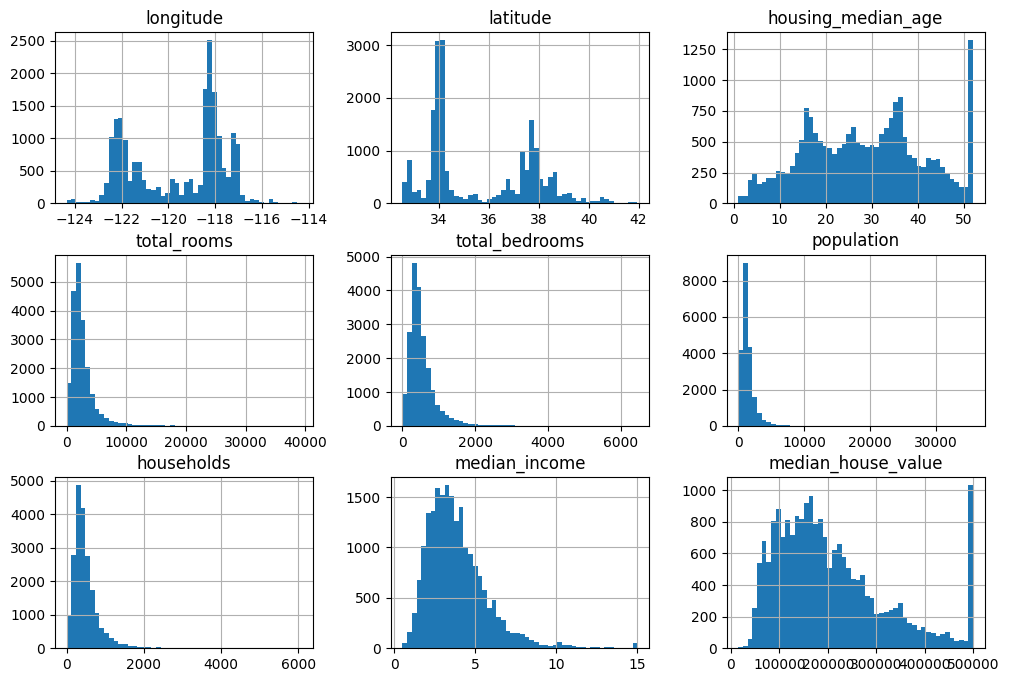

In [75]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

In [76]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

# dataframe[column].value_counts gives count of all values 
# Relativefrequencies = dataframe[column].value_counts(normalize=True).sort_index()
# Percentage = Relativefrequencies * 100
overall = housing["income_cat"].value_counts(normalize=True).sort_index()*100
random = test_set["income_cat"].value_counts(normalize=True).sort_index()*100
stratified = strat_test_set["income_cat"].value_counts(normalize=True).sort_index()*100

comparison = pd.DataFrame({"Overall %": overall.round(2), "Stratified %": stratified.round(2), "Random %": random.round(2), "Strat. Error %": (stratified - overall).round(2), "Rand. Error %": (random - overall).round(2)})
comparison


,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
income_cat,,,,,
1,3.98,4.00,4.02,0.01,0.04
2,31.88,31.88,32.44,-0.00,0.55
3,35.06,35.05,35.85,-0.00,0.79
4,17.63,17.64,16.74,0.00,-0.89
5,11.44,11.43,10.95,-0.01,-0.49


In [77]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

for set_ in (strat_train_set, strat_test_set):
    set_.drop("ocean_proximity", axis=1, inplace=True)

In [78]:
# strat_train_set copy of the original data
housing = strat_train_set.copy()
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0
...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0


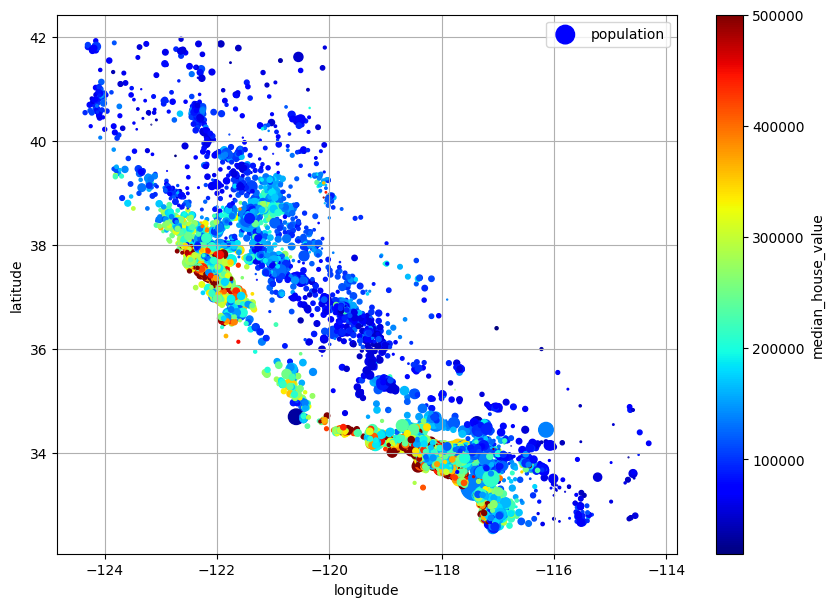

In [79]:
# c - A column name or position whose values will be used to color the marker points according to a colormap.
# s - A sequence of scalars, which will be used for each point's size recursively. For instance, when passing [2,14] all points size will be either 2 or 14, alternatively.
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"]/100, label="population", c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10, 7))
plt.show()

In [80]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

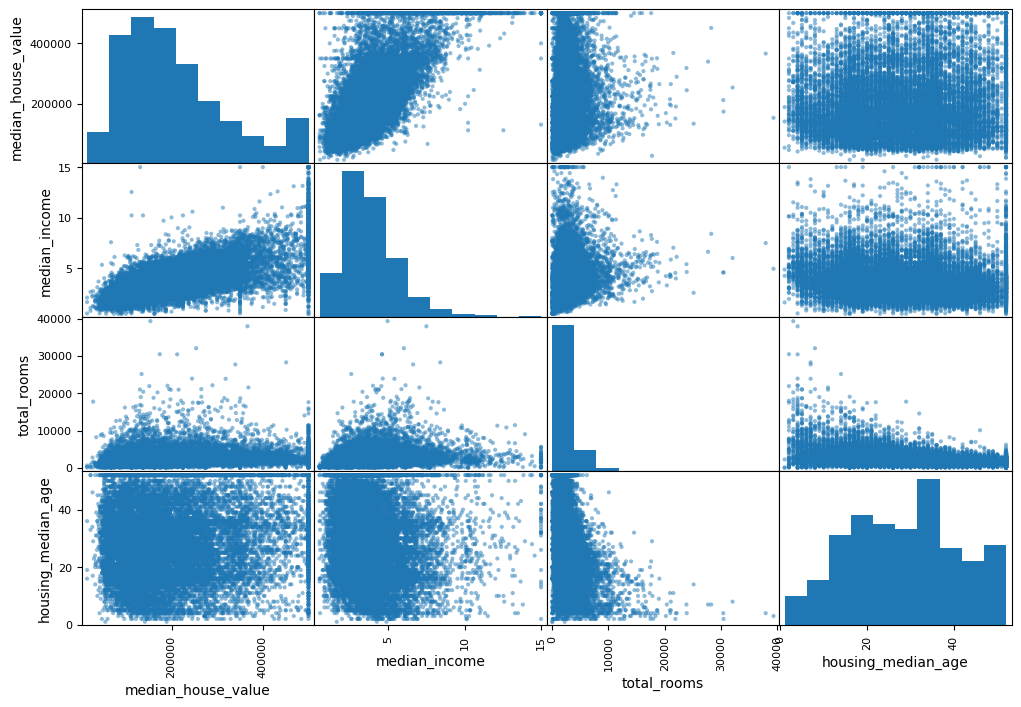

In [81]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

In [82]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [83]:
imputer = SimpleImputer(strategy="median")
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [84]:
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))

In [85]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self # always return self!
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

def column_ratio(X):
    return X[:, [0]]/ X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

# preprocessing = make_column_transformer([(ratio_pipeline(), ["total_bedrooms", "total_rooms"]), (ratio_pipeline, ["total_rooms", "households"]), (ratio_pipeline, ["population", "households"]), (log_pipeline, ["total_bedrooms", "total_rooms", "population",
# "households", "median_income"]), (cluster_simil, ["latitude", "longitude"]), (cat_pipeline, make_column_selector(dtype_include=object))], remainder=default_num_pipeline)

preprocessing = ColumnTransformer([
("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
("people_per_house", ratio_pipeline(), ["population", "households"]),
("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
"households", "median_income"]),
("geo", cluster_simil, ["latitude", "longitude"]),
("cat", cat_pipeline, make_column_selector(dtype_include=object)),
],
remainder=default_num_pipeline) # one column remaining: housing_median_age

In [86]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 19)

In [87]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'remainder__housing_median_age'],
      dtype=object)

In [88]:
# Training a model
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(gamma=1,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000138679AEC30>)])),
                ('linearregression', LinearRegression())])

In [89]:
# this output is way off
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([ 58900., 271400., 211100., 182400., 276100.])

In [90]:
housing_labels.iloc[:5].values

array([ 72100., 279600.,  82700., 112500., 238300.])

In [91]:
lin_rmse = mean_squared_error(housing_labels, housing_predictions)
print(lin_rmse)

4931974996.793758


In [92]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(gamma=1,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000138679AEC30>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [93]:
# this output is also way off
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

In [94]:
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

In [95]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     67449.346869
std       3048.353661
min      62862.804888
25%      65452.586628
50%      68156.247381
75%      69353.225046
max      72084.256729
dtype: float64

In [63]:
# this output is better
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

In [64]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47619.202645
std       2543.896486
min      43618.830744
25%      45173.983652
50%      48654.213911
75%      49431.108787
max      50569.890754
dtype: float64

In [98]:
full_pipeline = Pipeline([("preprocessing", preprocessing), ("random_forest", RandomForestRegressor(random_state=42)),])
param_grid = [{'preprocessing__geo__n_clusters': [5, 8, 10],'random_forest__max_features': [4, 6, 8]},{'preprocessing__geo__n_clusters': [10, 15],'random_forest__max_features': [6, 8, 10]},]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error")
grid_search.fit(housing, housing_labels)
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [103]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters", "param_random_forest__max_features", "split0_test_score", "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43268,44737,45065,44357
13,15,8,44303,45115,45958,45125
6,10,4,44060,45794,45995,45283
14,15,10,44823,45619,46364,45602
7,10,6,44681,46072,46714,45823


In [105]:
param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),'random_forest__max_features': randint(low=2, high=20)}
rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)
rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013866E16630>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013867A27EC0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [106]:
final_model = rnd_search.best_estimator_
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.08, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.2 , 0.01, 0.02, 0.02,
       0.01, 0.01, 0.01, 0.03, 0.01, 0.  , 0.01, 0.03, 0.02, 0.01, 0.02,
       0.  , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.03,
       0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01,
       0.01, 0.01, 0.02, 0.01, 0.  , 0.01, 0.  , 0.04, 0.01, 0.01])

In [108]:
sorted(zip(feature_importances, final_model["preprocessing"].get_feature_names_out()), reverse=True)

[(np.float64(0.20067437452573123), 'log__median_income'),
 (np.float64(0.07976108740589248), 'bedrooms__ratio'),
 (np.float64(0.05384697950543674), 'rooms_per_house__ratio'),
 (np.float64(0.05162760001933593), 'people_per_house__ratio'),
 (np.float64(0.04110291389330096), 'geo__Cluster 43 similarity'),
 (np.float64(0.03355112848522034), 'geo__Cluster 6 similarity'),
 (np.float64(0.030143947134313447), 'geo__Cluster 24 similarity'),
 (np.float64(0.025831082536126905), 'geo__Cluster 10 similarity'),
 (np.float64(0.022505233381596684), 'geo__Cluster 2 similarity'),
 (np.float64(0.02238162417969191), 'geo__Cluster 11 similarity'),
 (np.float64(0.021580049882945714), 'geo__Cluster 15 similarity'),
 (np.float64(0.018310497714518432), 'geo__Cluster 26 similarity'),
 (np.float64(0.01829399286324614), 'geo__Cluster 13 similarity'),
 (np.float64(0.01693068366420719), 'geo__Cluster 1 similarity'),
 (np.float64(0.015639968656621303), 'geo__Cluster 23 similarity'),
 (np.float64(0.015506931257371787

In [109]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
final_predictions = final_model.predict(X_test)
final_rmse = mean_squared_error(y_test, final_predictions)
print(final_rmse)

1578969918.8444958


In [111]:
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([37893.58513848, 41497.18114573])